# Classificador de notícies

Aquest notebook conté el procés de fer fine-tuning de CatalanULMFit entrenat amb el dump de Wikipedia.
- Primer entrenarem tot el LM amb la nostra data
- Després agafarem només l'encoder i crearem un objecte classifier on top per a realitzar la tasca desitjada.

## Instal·lant dependències

In [2]:
import os
import seaborn as sns
from fastai import *
from fastai.text import *

import numpy as np
import pandas as pd

from pathlib import Path
from functools import partial

## Fine-tuning per al classificador

### Load dataset

In [3]:
data = pd.read_csv('data.csv', delimiter='|', error_bad_lines=False)
data.drop_duplicates()
data['Article'] = data['Article'].str.replace("[^a-zA-Z]", " ")
data = data.dropna()
data


,Type,Article
0,SPORTS,L Olot es va posar en marxa ahir amb u...
1,SPORTS,El treball en equip fa que els somnis es comp...
2,SPORTS,El migcampista saltenc Dani Toribio que tenia...
3,SPORTS,El Figueres de Javi Salamero va iniciar ahir a...
4,SPORTS,Un solitari gol de Kingsley Mengin en la segon...
...,...,...
891,SALUT,Segurament posar nos a les mans d un fisiotera...
892,SALUT,L aplicaci de rastreig de contagis promoguda ...
893,SALUT,Dermavision Solutions una empresa de Roses h...
894,SALUT,Les persones amb obesitat que s aprimen no a ...


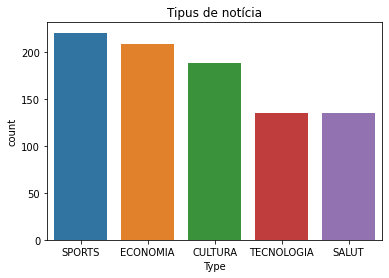

In [4]:
sns.countplot(x=data["Type"])
plt.title("Tipus de notícia")
plt.show()

In [5]:
data.shape
data['valid']=0
data['valid'][:int(data.shape[0]*0.15)]=1
data= data[['Article','Type', 'valid']]
data.to_csv(os.path.join('.', 'train_classifier.csv'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
tokenizer = Tokenizer(lang='ca', n_cpus=5)
data_lm = TextLMDataBunch.from_csv('.', tokenizer=tokenizer, bs=16, valid_pct=0.1, csv_name='train_classifier.csv')
data_lm.save('data_lm_finetuning')
data_lm.train_ds.vocab.itos[:]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'de',
 'la',
 'a',
 'que',
 's',
 'i',
 'el',
 'l',
 'en',
 'per',
 'd',
 'les',
 'un',
 'els',
 'm',
 'amb',
 'del',
 'una',
 'ha',
 'es',
 'al',
 'va',
 'no',
 'com',
 'dels',
 'o',
 'n',
 'aquest',
 'hi',
 'ncia',
 'ser',
 'aix',
 'tamb',
 'han',
 'seva',
 'entre',
 'tot',
 'molt',
 'seu',
 'ja',
 'als',
 'se',
 't',
 'si',
 'van',
 'girona',
 'anys',
 'aquesta',
 'fer',
 'b',
 'ria',
 'est',
 'fins',
 'des',
 'seus',
 'perqu',
 'despr',
 'pel',
 'segons',
 'ho',
 'any',
 'durant',
 'sobre',
 'p',
 'on',
 'fa',
 'pot',
 'fet',
 'nom',
 'altres',
 'cap',
 'quan',
 'estat',
 'tots',
 'persones',
 'c',
 'encara',
 'part',
 'ara',
 'covid',
 'ens',
 'pr',
 'dues',
 'mateix',
 'dos',
 'tenir',
 'gran',
 'aquests',
 'tiktok',
 'primera',
 'poden',
 'qu',
 'mia',
 'li',
 'col',
 'tres',
 'ncies',
 'tant',
 'temps',
 'em',
 'pa',
 'qual',
 'sense',
 'abans',
 'dia',
 'hem',
 'primer',
 'f',
 'nou',
 '

In [7]:
tokenizer = Tokenizer(lang='ca', n_cpus=5)
data_lm = TextLMDataBunch.from_csv('.', tokenizer=tokenizer, bs=16, valid_pct=0.1, csv_name='train_classifier.csv')

In [8]:
len(data_lm.train_ds.vocab.itos[:])

11200

### Fine-tuning del Language Model amb la nostra data

Primer, abans d'entrenar el classificador (només fent servir l'encoder) fem *fine-tuning* amb la nostra data. Tot i que el model ha estat entrenat amb un dataset de domini-general molt divers, probablement la nostra data té una distribució diferent.

(recorda pujar al Colab els weights i els itos)

In [9]:
weights_pretrained='model_60k-vocab-2'
itos_pretrained='itos'
pretrained_data=(weights_pretrained, itos_pretrained)

In [10]:
!mkdir models
!cp model_60k-vocab-2.pth models/
!cp itos.pkl models/

In [11]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=pretrained_data, drop_mult=0)
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot(show_grid=True, suggestion=True)

In [12]:
# entrenem el learner un epoch
learn.fit_one_cycle(1, 3e-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.013836,2.821997,0.509986,18:57


In [13]:
learn.unfreeze()
learn.fit_one_cycle(6,1e-02, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.214303,2.792412,0.481320,34:26
1,2.617223,2.828088,0.473191,35:19
2,1.918978,2.194183,0.573097,35:51
3,0.821320,1.400396,0.740343,34:57
4,0.542360,1.040318,0.823990,34:41
5,0.236891,1.026646,0.835385,34:59


In [14]:
learn.save_encoder('ft_enc')

### Fine-tuning de l'encoder

Ara toca entrenar el classificador utilitzant només l'encoder. 

In [15]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data,test_size=0.2)

df_train.to_csv('news_train.csv')
df_test.to_csv('news_test.csv')

In [ ]:
df_train

In [ ]:
df_test

In [16]:
data_lm = TextClasDataBunch.from_csv(path='.',csv_name='news_train.csv',
                              vocab=data_lm.train_ds.vocab,bs=64, text_cols='Article',label_cols='Type', tokenizer=tokenizer)
data_lm.save('data_lm_classifier')


In [17]:
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
xxbos xxmaj la not cia del comprom s per a una fusi entre caixabank i xxmaj bankia va arribar de forma atropellada a la mitjanit de dijous i divendres va despertar les borses amb un sonor aplaudiment a l operaci financera que si prospera donar a llum aviat la primera entitat espanyola per volum d actius de cr dits de dip sits d oficines i empleats a xxmaj espanya xxmaj,ECONOMIA
xxbos xxmaj la not cia del comprom s per a una fusi entre caixabank i xxmaj bankia va arribar de forma atropellada a la mitjanit de dijous i divendres va despertar les borses amb un sonor aplaudiment a l operaci financera que si prospera donar a llum aviat la primera entitat espanyola per volum d actius de cr dits de dip sits d oficines i empleats a xxmaj espanya xxmaj,ECONOMIA
xxbos xxmaj allunyat des de feia un parell d anys del m n de l esport despr s d una llarga etapa com a periodista especialitzat en b squet el giron xxmaj jordi xxmaj pl estava treballant com a mediador a c ritas quan va rebre una inesperada trucada de xxmaj marc xxmaj gasol xxmaj el pivot dels xxmaj raptors el volia com a director esportiu del b squet xxmaj,SPORTS
xxbos xxmaj les presentacions d xxmaj apple queden gravades en la mem ria xxmaj sobretot en un temps en el qual els assistents esperaven el gest i les paraules m giques de xxmaj steve xxmaj jobs quan gaireb al final de l esdeveniment i ficant la m en la seva butxaca deia hi ha una cosa m s i tots sense excepci sabien que una cosa gran estava a punt,TECNOLOGIA
xxbos xxmaj les presentacions d xxmaj apple queden gravades en la mem ria xxmaj sobretot en un temps en el qual els assistents esperaven el gest i les paraules m giques de xxmaj steve xxmaj jobs quan gaireb al final de l esdeveniment i ficant la m en la seva butxaca deia hi ha una cosa m s i tots sense excepci sabien que una cosa gran estava a punt,TECNOLOGIA


In [18]:
data_lm.vocab.itos[:100]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'de',
 'la',
 'a',
 'que',
 's',
 'i',
 'el',
 'l',
 'en',
 'per',
 'd',
 'les',
 'un',
 'els',
 'm',
 'amb',
 'del',
 'una',
 'ha',
 'es',
 'al',
 'va',
 'no',
 'com',
 'dels',
 'o',
 'n',
 'aquest',
 'ncia',
 'hi',
 'ser',
 'aix',
 'tamb',
 'han',
 'seva',
 'tot',
 'molt',
 'seu',
 'entre',
 'se',
 'als',
 'ja',
 'si',
 't',
 'girona',
 'anys',
 'van',
 'aquesta',
 'fer',
 'b',
 'ria',
 'est',
 'seus',
 'des',
 'segons',
 'fins',
 'pel',
 'despr',
 'perqu',
 'ho',
 'any',
 'durant',
 'sobre',
 'pot',
 'fa',
 'p',
 'on',
 'fet',
 'altres',
 'quan',
 'nom',
 'cap',
 'estat',
 'c',
 'tots',
 'persones',
 'encara',
 'ara',
 'ens',
 'covid',
 'part',
 'mateix',
 'tenir',
 'dues',
 'pr',
 'aquests',
 'dos',
 'gran',
 'poden',
 'sense',
 'tiktok']

In [19]:
learn = text_classifier_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [20]:
learn.load_encoder('ft_enc')
learn.freeze

<bound method Learner.freeze of RNNLearner(data=TextClasDataBunch;

Train: LabelList (568 items)
x: TextList
xxbos xxmaj el nou conseller d xxmaj empresa de la xxmaj generalitat xxmaj ramon xxmaj tremosa va assegurar ahir que li agradaria que caixabank retorn s a xxmaj barcelona la seva seu social i fiscal que des d octubre de s a xxmaj val ncia i ha anunciat que treballar perqu aix sigui xxmaj aix mateix es va mostrar preocupat pel fet que una fusi reduiria encara m s el nombre d entitats que operen en el sistema financer espanyol donant lloc a una situaci d oligopoli i que aix podria anar en detriment de la compet ncia i per tant dels usuaris xxmaj en la mateixa l nia xxmaj podem va advertir que el moviment que permetria crear el major grup bancari d xxmaj espanya suposar un aprofundiment en la concentraci del sector bancari i tindr un impacte negatiu en l ocupaci xxmaj el secretari d xxmaj economia de xxmaj podem xxmaj nacho lvarez considera que l xxmaj estat no ha d abandonar la se

In [ ]:
learn.lr_find()
learn.recorder.plot(show_grid=True, suggestion=True)

In [21]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(11200, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(11200, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, 

In [22]:
learn.fit_one_cycle(2,3.02E-03, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.125700,1.356522,0.699301,07:34
1,0.782912,1.129766,0.755245,07:27


In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(3.02E-03/(2.6**4), 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.537427,0.621412,0.923077,08:15


In [24]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(3.02E-03/(2.6**4), 5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.313477,0.426240,0.944056,12:05


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(3.02E-03/(2.6**4), 5e-3), moms=(0.8,0.7))

In [29]:
learn.save('classificador_noticies')

# Testejar el classificador


In [37]:
val_preds,val_targets, losses = learn.get_preds(with_loss=True)

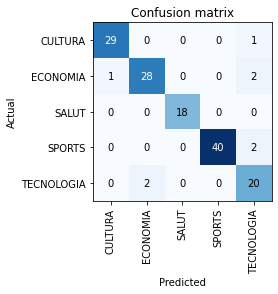

In [39]:
interp = ClassificationInterpretation(learn, val_preds, val_targets, losses)
interp.plot_confusion_matrix()